<a href="https://colab.research.google.com/github/mobilttterbang/Stock-Price-Forecast-ARIMA-LSTM-/blob/main/Time_Series_Price_Stocks_Hybrid_ARIMA_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pmdarima
!pip install scikeras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 48.6 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.3.2
    Uninstalling scikit-learn-1.3.2:
      Successfully uninstalled scikit-learn-1.3.2


In [ ]:
################# Load package ###################
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scikeras
import warnings

%matplotlib inline
warnings.filterwarnings("ignore")

from pylab import rcParams
from pandas import read_csv
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, train_test_split
from tensorflow.keras.layers import Dense,Dropout,SimpleRNN,LSTM
from scikeras.wrappers import KerasRegressor
from tensorflow.python.keras.models import Sequential
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import boxcox

In [ ]:
###################### ARIMA #######################
df = pd.read_csv(r'/content/BCA91.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2022-11-21,8875.0,8900.0,8725.0,8725.0,8289.276367,35901000
1,2022-11-22,8900.0,8950.0,8850.0,8900.0,8455.536133,84684200
2,2022-11-23,8900.0,8975.0,8875.0,8875.0,8431.785156,84642100
3,2022-11-24,8975.0,9000.0,8950.0,9000.0,8550.542969,53520800
4,2022-11-25,9000.0,9000.0,8900.0,8975.0,8526.791016,75048300


[]

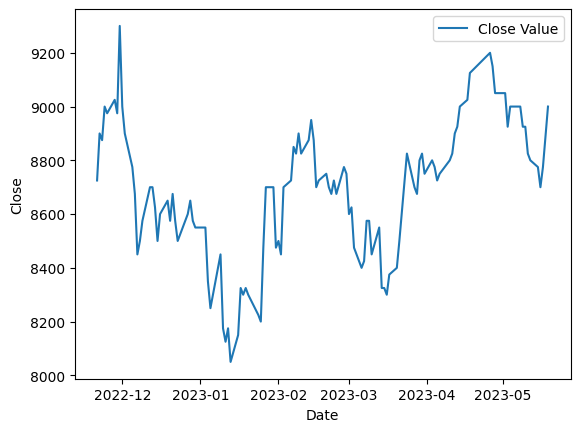

In [ ]:
# Assuming your data has a monthly frequency, set the period accordingly
period = 12

# Convert the index to DatetimeIndex if it's not already
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

sns.lineplot(df['Close'], label='Close Value')
plt.plot()

In [ ]:
# Extract value for Seasonal
result=seasonal_decompose(df['Close'], period=12, model='multiplicative', two_sided=False)
df['trend']=result.trend
df['seasonal']=result.seasonal
df['residual']=result.resid

In [ ]:
print(f'the new data shape: {df.shape}')
df.head()

the new data shape: (119, 9)


,Open,High,Low,Close,Adj Close,Volume,trend,seasonal,residual
Date,,,,,,,,,
2022-11-21,8875.0,8900.0,8725.0,8725.0,8289.276367,35901000,NaN,0.997175,NaN
2022-11-22,8900.0,8950.0,8850.0,8900.0,8455.536133,84684200,NaN,0.996587,NaN
2022-11-23,8900.0,8975.0,8875.0,8875.0,8431.785156,84642100,NaN,0.997353,NaN
2022-11-24,8975.0,9000.0,8950.0,9000.0,8550.542969,53520800,NaN,0.996549,NaN
2022-11-25,9000.0,9000.0,8900.0,8975.0,8526.791016,75048300,NaN,0.999152,NaN


In [ ]:
df[df['trend'].isna() == False].index

DatetimeIndex(['2022-12-07', '2022-12-08', '2022-12-09', '2022-12-12',
               '2022-12-13', '2022-12-14', '2022-12-15', '2022-12-16',
               '2022-12-19', '2022-12-20',
               ...
               '2023-05-05', '2023-05-08', '2023-05-09', '2023-05-10',
               '2023-05-11', '2023-05-12', '2023-05-15', '2023-05-16',
               '2023-05-17', '2023-05-19'],
              dtype='datetime64[ns]', name='Date', length=107, freq=None)

In [ ]:
# Ambil data trend untuk ARIMA
df_train = df.dropna()
index_len = int(len(df_train)*0.8)
df_train = df_train.loc[df_train.index[0:index_len], 'trend'].to_frame()
df_train

,trend
Date,
2022-12-07,8915.625000
2022-12-08,8887.500000
2022-12-09,8858.333333
2022-12-12,8833.333333
2022-12-13,8809.375000
...,...
2023-04-03,8586.458333
2023-04-04,8625.000000
2023-04-05,8661.458333


In [ ]:
#Uji Stationer for Trend Feature
from statsmodels.tsa.stattools import adfuller

def adfuller_test(harga):
    if isinstance(harga, pd.Series):
        harga = harga.dropna().values  # Handle potential missing values
    result=adfuller(harga)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )

adfuller_test(df_train['trend'])

ADF Test Statistic : -2.4916016299835904
p-value : 0.1175311342725937
#Lags Used : 6
Number of Observations : 78


ADF Test Statistic : -3.27432222394672
p-value : 0.01606602182988835
#Lags Used : 9
Number of Observations : 74


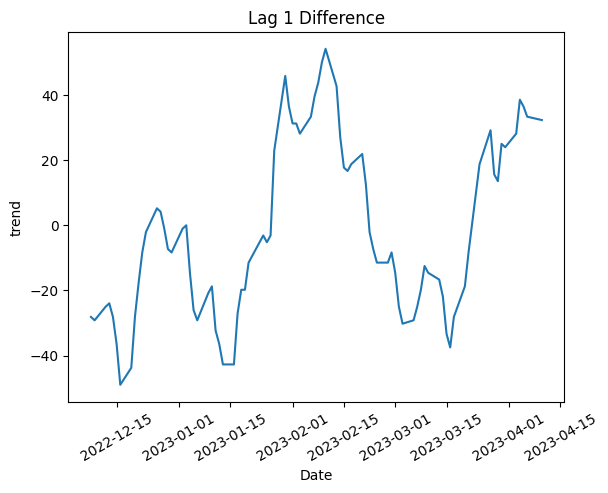

In [ ]:
# Differencing
# df_train['Close First Difference'] = df_train - df_train.shift(1)

#Uji ADF Ulang
adfuller_test(df_train['trend'].diff().dropna())
sns.lineplot(x=df_train.index, y=df_train['trend'].diff())
plt.title('Lag 1 Difference')
plt.xticks(rotation=30)
plt.show()

ADF Test Statistic : -3.2746052862373873
p-value : 0.0160524894114948
#Lags Used : 9
Number of Observations : 74


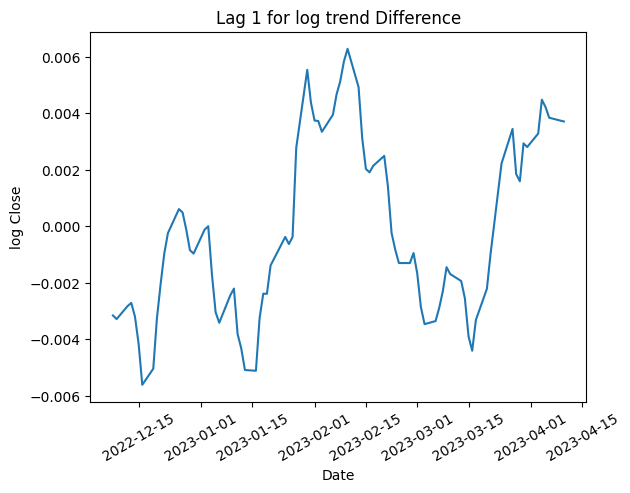

In [ ]:
# Log Differencing
df_train['log Close'] = np.log(df_train['trend'])
# df_train['log Close diff'] = df_train['log Close'] - df_train['log Close'].shift(1)

#Uji ADF Ulang
adfuller_test(df_train['log Close'].diff().dropna())
sns.lineplot(x=df_train.index, y=df_train['log Close'].diff())
plt.title('Lag 1 for log trend Difference')
plt.xticks(rotation=30)
plt.show()

In [ ]:
df_train.head()

,trend,log Close
Date,,
2022-12-07,8915.625000,9.095561
2022-12-08,8887.500000,9.092401
2022-12-09,8858.333333,9.089114
2022-12-12,8833.333333,9.086288
2022-12-13,8809.375000,9.083572


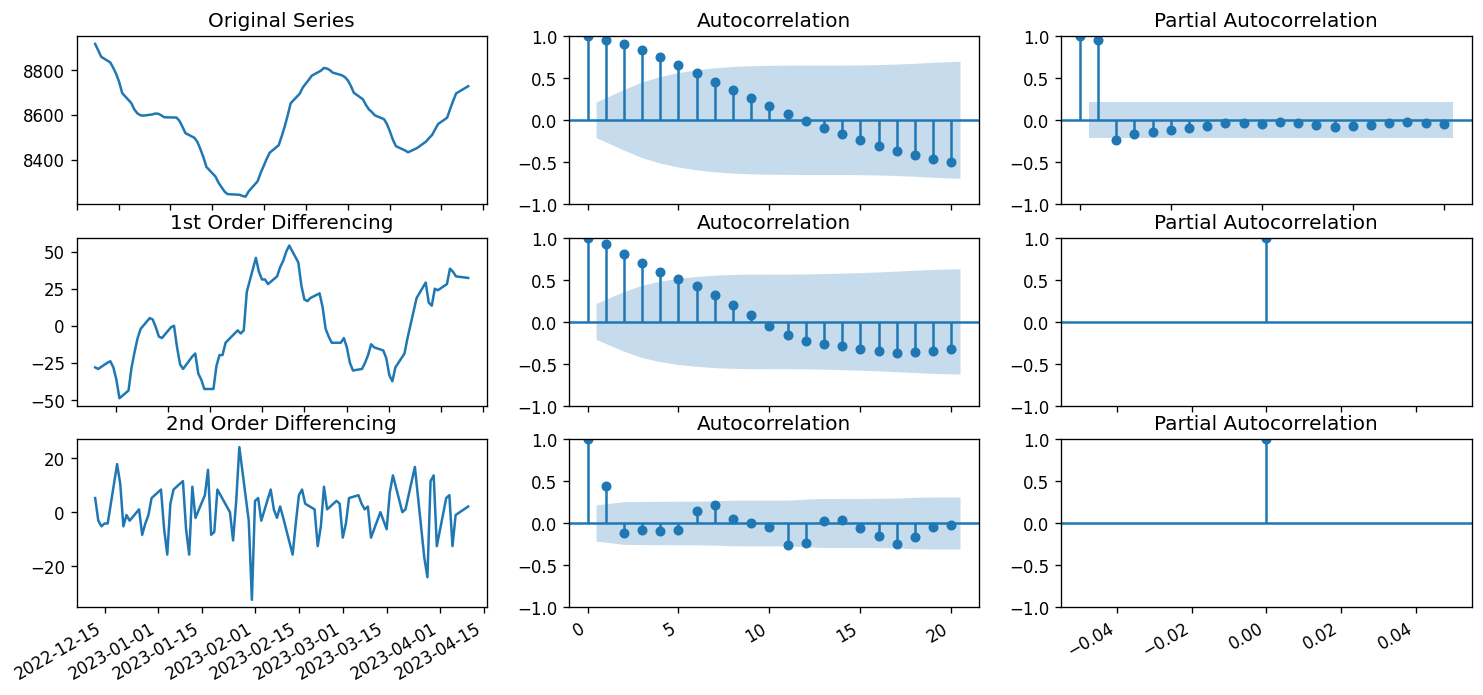

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 3, figsize=(15,7))
# sns.lineplot(x=df_train['trend'].index, y=df_train['trend'], ax=axes[0, 0])
plot_acf(df_train['trend'], ax=axes[0, 1])
plot_pacf(df_train['trend'], ax=axes[0,2])
axes[0, 0].plot(df_train['trend'])
axes[0, 0].set_title('Original Series')

# 1st Differencing
plot_acf(df_train['trend'].diff().dropna(), ax=axes[1, 1])
plot_pacf(df_train['trend'].diff(), ax=axes[1,2])
axes[1, 0].plot(df_train['trend'].diff())
axes[1, 0].set_title('1st Order Differencing')

# 2nd Differencing
plot_acf(df_train['trend'].diff().diff().dropna(), ax=axes[2, 1])
plot_pacf(df_train['trend'].diff().diff(), ax=axes[2,2])
axes[2, 0].plot(df_train['trend'].diff().diff().diff())
axes[2, 0].set_title('2nd Order Differencing')

fig.autofmt_xdate()
plt.show()

1. For the above data, we can see that the time series reaches stationarity with **2nd ORDER of DIFFERENCING**
2. for PACF plot in 1 diff we can see PACF Lag 1 quite significant since it is well above the significance line with **p = 1**
3. for ACF plot in 1 diff we can see ACF Lag 1 quite significant since it is well above the significance line with **q = 4** (0 1 2 3 4)

d = 1

In [ ]:
#Model ARIMA
from pmdarima.arima import auto_arima

model = auto_arima(
    df_train['trend'],
    start_p=0, start_q=0,
    max_p=1, max_q=4,
    test = 'adf',
    m = 1,
    d = None,
    trace=True,
    error_action="ignore",
    suppress_warnings=True,
    stepwise = True
    )

model.fit(df_train['trend'])

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=598.249, Time=0.19 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=581.723, Time=0.23 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=inf, Time=1.96 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.89 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=583.511, Time=0.06 sec

Best model:  ARIMA(1,2,0)(0,0,0)[0]          
Total fit time: 3.499 seconds


ARIMA(order=(1, 2, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [ ]:
# Model Performance
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

# define test set
df_test = df.iloc[index_len+1:]
pem_test1 = pd.to_numeric(df_test["Close"])

fc = model.predict(start = '2023-03-24', end = '2023-05-19')
pred_test = pd.to_numeric(fc)

def forecast_accuracy(forecast, actual, forecast1, actual1):
    mae = mean_absolute_error(actual, forecast)
    mape = mean_absolute_percentage_error(actual, forecast)
    rmse = mean_squared_error(actual, forecast, squared=False)
    return({'MAE':mae, 'MAPE':mape, 'RMSE':rmse})

ARIMA_metrics = forecast_accuracy(pred_test.values[0:5], pem_test1.values[0:5], pred_test.values[0:5], pem_test1.values[0:5])
print(f'MAE: {ARIMA_metrics["MAE"]}')
print(f'MAPE: {ARIMA_metrics["MAPE"]}')
print(f'RMSE: {ARIMA_metrics["RMSE"]}')
print()

MAE: 83.45565860607931
MAPE: 0.009547290178822056
RMSE: 90.18312162141517



/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [ ]:
# sns.barplot(pred_test.values[0:5])
# sns.barplot(pem_test1.values[0:5])
print(pred_test.values[0:5])
print()
print(pem_test1.values[0:5])

[8758.91209142 8790.53513653 8822.06676439 8853.55776714 8885.03071639]

[8825. 8700. 8675. 8800. 8825.]


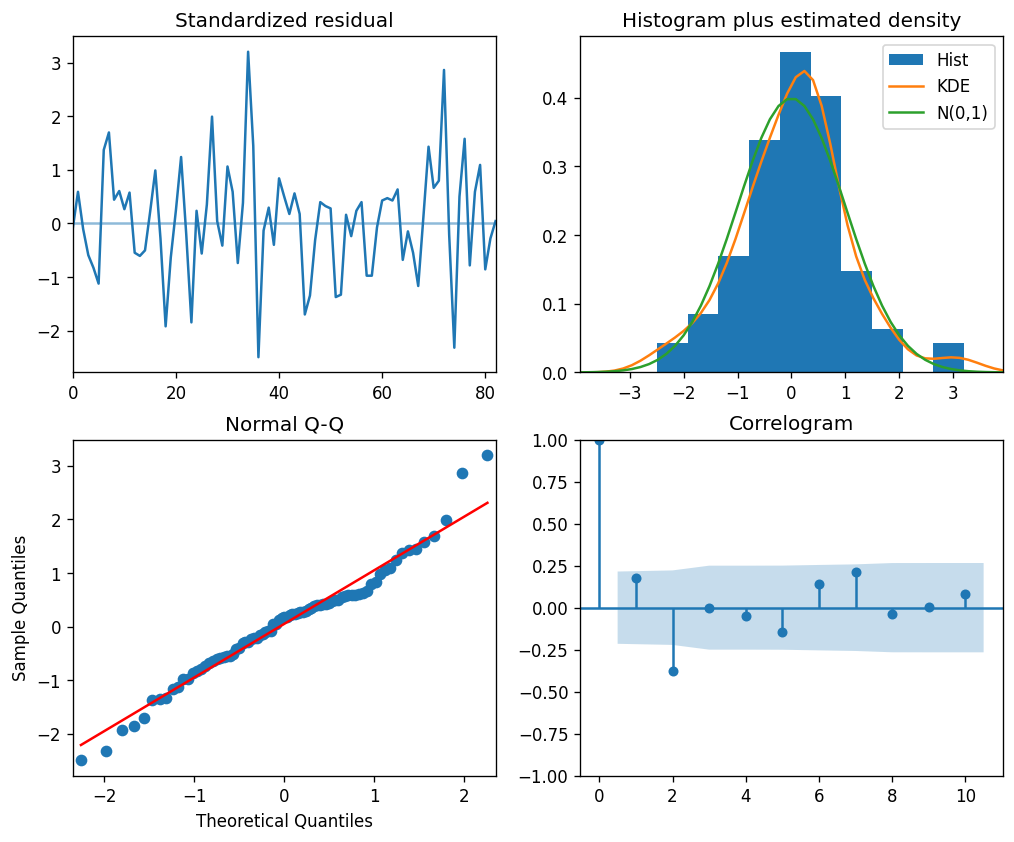

In [ ]:
model.plot_diagnostics(figsize=(10,8))
plt.show()

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# 1,2,0 ARIMA Model
model = ARIMA(df_train.trend, order=(1,2,0))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  trend   No. Observations:                   85
Model:                 ARIMA(1, 2, 0)   Log Likelihood                -288.862
Date:                Thu, 08 Aug 2024   AIC                            581.723
Time:                        10:58:28   BIC                            586.561
Sample:                             0   HQIC                           583.667
                                 - 85                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4444      0.087      5.088      0.000       0.273       0.616
sigma2        61.5619      7.678      8.018      0.000      46.514      76.610
Ljung-Box (L1) (Q):                   2.69   Jarque-

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


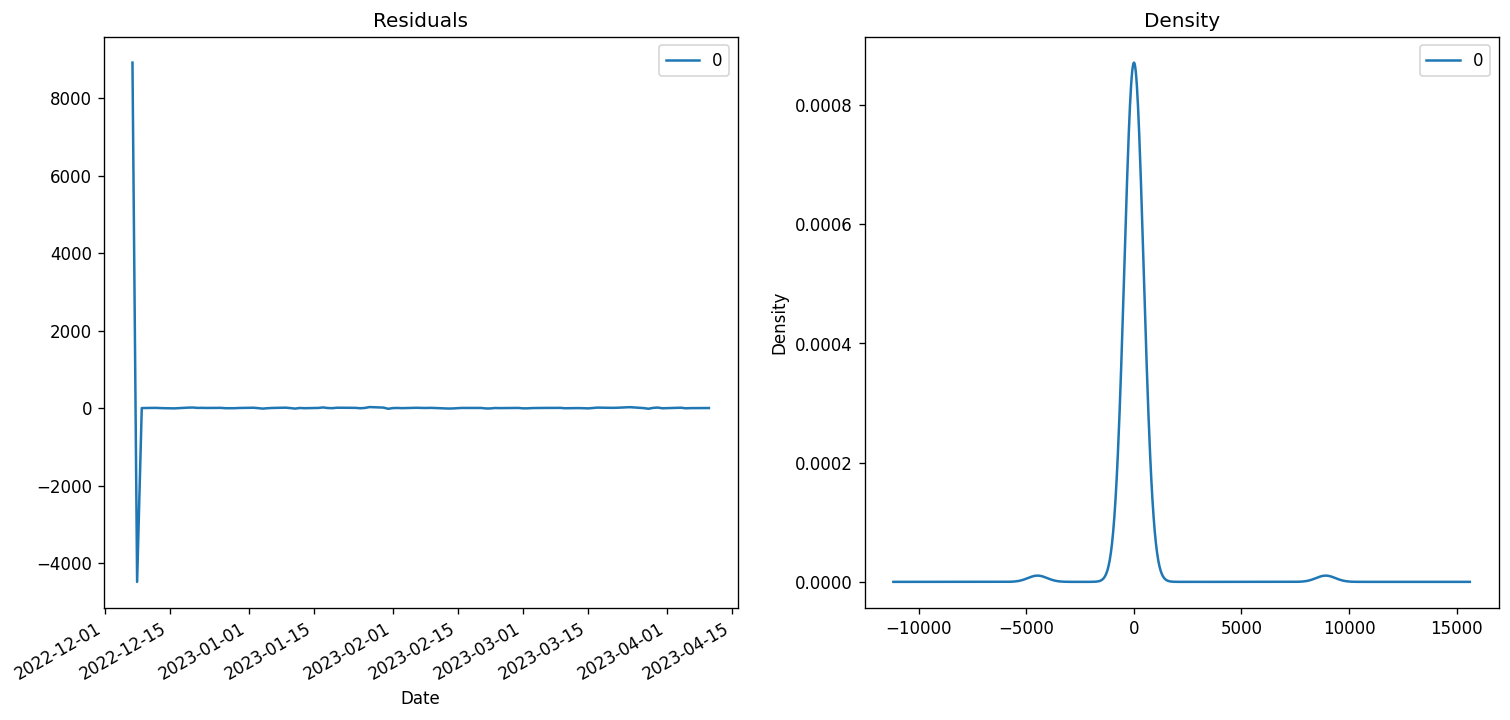

In [ ]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2, figsize=(15,7))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


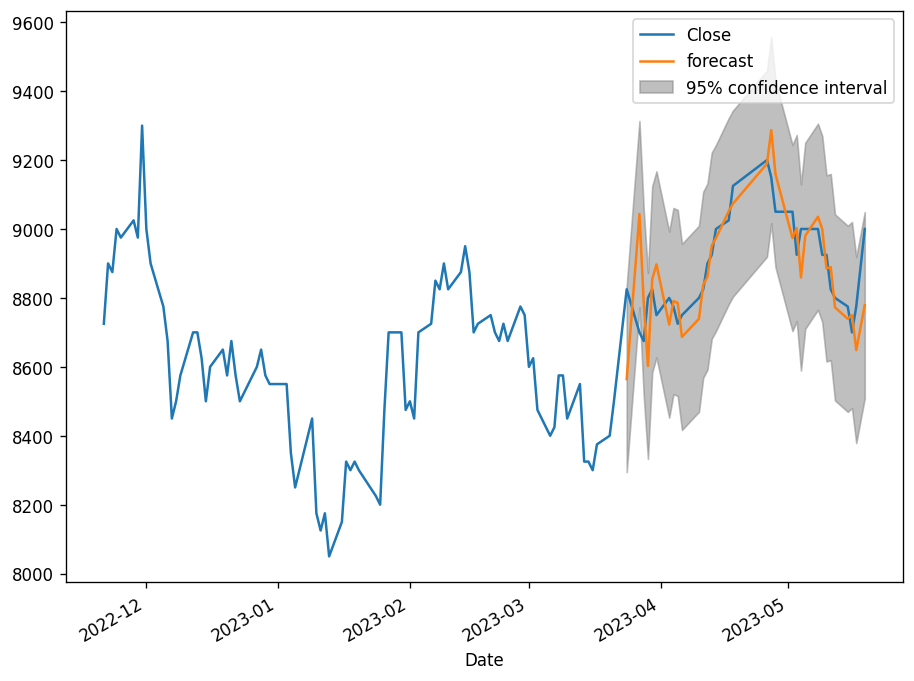

In [ ]:
# Actual vs Fitted
from statsmodels.graphics.tsaplots import plot_predict

res = ARIMA(df.Close, order=(1,2,0)).fit()
fig, ax = plt.subplots()
ax = df.Close.plot(ax=ax)
plot_predict(res, index_len+1, ax=ax)
plt.show()

In [ ]:
################## LSTM #####################

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Assuming you have a time series dataset stored in a pandas DataFrame named 'df'
# with a single column of values representing your time series data.

# MODEL SEASONAL
data = np.array(df['seasonal']).reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Function to create a dataset for LSTM
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data)-time_step-1):
        a = data[i:(i+time_step), 0]
        X.append(a)
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

# Create the dataset with a time step (you may adjust this as needed)
time_step = 5
X, Y = create_dataset(scaled_data, time_step)

# Reshape X to be suitable for LSTM (samples, time steps, features)
X = X.reshape(X.shape[0], X.shape[1], 1)

# Splitting into train and test sets (adjust as needed)
train_size = int(len(X) * 0.9)
test_size = len(X) - train_size
train_X, test_X = X[0:train_size], X[train_size:len(X)]
train_Y, test_Y = Y[0:train_size], Y[train_size:len(Y)]

def create_lstm_model(units=50, optimizer='adam'):
    model = Sequential()
    model.add(LSTM(units=units, activation = 'relu', return_sequences=True, input_shape=(time_step, 1)))
    model.add(LSTM(units=units))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

model = KerasRegressor(build_fn=create_lstm_model, verbose=0)

# Time series cross-validator
tscv = TimeSeriesSplit(n_splits=3)

# Define the LSTM model
model1 = Sequential()
model1.add(LSTM(units=50, activation = 'relu', return_sequences=True, input_shape=(time_step, 1)))
model1.add(LSTM(units=50))
model1.add(Dense(units=1))

# Compile the model
model1.compile(optimizer='adam', loss='mean_squared_error')

# Fit the model
model1.fit(train_X, train_Y, epochs=50, batch_size=32)

# Predicting for test data
predicted_Y = model1.predict(test_X)

# Inverse transform the predictions
predicted_Y = scaler.inverse_transform(predicted_Y)

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.2294
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1838 
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1564 
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1213 
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1056 
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0967 
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0984 
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0891 
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0986 
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0846
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0925 
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0864 
Epoch 13/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0814
Epoch 14/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0878
Epoch 15/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0837
Epoch 16/50
4/4 ━━━━━━━━━━━━━━

In [ ]:
predicted_Y

array([[0.9987216 ],
       [0.9986606 ],
       [0.99863786],
       [0.9985739 ],
       [0.9987649 ],
       [0.99777204],
       [0.9988971 ],
       [1.0036088 ],
       [1.0035852 ],
       [1.0023329 ],
       [1.0014021 ],
       [0.99937516]], dtype=float32)

In [ ]:
# MODEL RESIDUAL
data = np.array(df['residual'].dropna()).reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Function to create a dataset for LSTM
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data)-time_step-1):
        a = data[i:(i+time_step), 0]
        X.append(a)
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

# Create the dataset with a time step (you may adjust this as needed)
time_step = 5
X, Y = create_dataset(scaled_data, time_step)

# Reshape X to be suitable for LSTM (samples, time steps, features)
X = X.reshape(X.shape[0], X.shape[1], 1)

# Splitting into train and test sets (adjust as needed)
train_size = int(len(X) * 0.9)-1
test_size = len(X) - train_size
train_X, test_X = X[0:train_size], X[train_size:len(X)]
train_Y, test_Y = Y[0:train_size], Y[train_size:len(Y)]

# Hypertunning parameter
def create_lstm_model(units=50, optimizer='adam'):
    model = Sequential()
    model.add(LSTM(units=units, activation = 'relu', return_sequences=True, input_shape=(time_step, 1)))
    model.add(LSTM(units=units))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

model = KerasRegressor(build_fn=create_lstm_model, verbose=0)

# Time series cross-validator
tscv = TimeSeriesSplit(n_splits=3)

# Define the LSTM model
model2 = Sequential()
model2.add(LSTM(units=50, activation='relu', return_sequences=True, input_shape=(time_step, 1)))
model2.add(LSTM(units=50))
model2.add(Dense(units=1))

# Compile the model
model2.compile(optimizer='adam', loss='mean_squared_error')

# Fit the model
model2.fit(train_X, train_Y, epochs=50, batch_size=32)

# Predicting for test data
predicted_Y1 = model2.predict(test_X)

# Inverse transform the predictions
predicted_Y1 = scaler.inverse_transform(predicted_Y1)

Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.2522
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1996 
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1652 
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1185
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0942
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0479  
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0269
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0280 
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0355
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0384 
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0283 
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0245
Epoch 13/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0251
Epoch 14/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0274
Epoch 15/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0228 
Epoch 16/50
3/3 ━━━━━━━━━━━━━━━━━

In [ ]:
predicted_Y1

array([[1.0179433 ],
       [1.0166819 ],
       [1.0116053 ],
       [1.0071453 ],
       [1.0031476 ],
       [1.0011637 ],
       [0.99947447],
       [0.9993003 ],
       [0.99600035],
       [0.99223536],
       [0.98848474],
       [0.9857142 ]], dtype=float32)

In [ ]:
X.shape

(101, 5, 1)

In [ ]:
hasil_arima_lstm = pred_test.values[0:10] + np.reshape(predicted_Y[0:10], (10, )) + np.reshape(predicted_Y1[0:10], (10, ))
print('prediksi ARIMA-LSTM : ',hasil_arima_lstm,'\n')
print('Hasil Hybrid ARIMA-LSTM adalah : ',forecast_accuracy(hasil_arima_lstm ,pem_test1.values[0:10], hasil_arima_lstm , pem_test1.values[0:10]),'\n')

prediksi ARIMA-LSTM :  [8760.92875628 8792.55047907 8824.07700751 8855.56348632 8887.03262887
 8918.49457858 8949.95537551 8981.41968985 9012.87543897 9044.32918147] 

Hasil Hybrid ARIMA-LSTM adalah :  {'MAE': 153.03691098663276, 'MAPE': 0.01748785373693406, 'RMSE': 174.5904003989891} 



In [ ]:
# Actual vs Fitted
from statsmodels.graphics.tsaplots import plot_predict

test_idx = int(len(df)*0.8) - 1

# define test set
train = df.Close[:(test_idx-1)]
test = df.Close[test_idx:]
y_actual = pd.to_numeric(test)

In [ ]:
# Load data to predict
df_resid = np.array(df['residual'].dropna()).reshape(-1, 1)
df_season = np.array(df['seasonal'].dropna()).reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_resid = scaler.fit_transform(df_resid)
scaled_season = scaler.fit_transform(df_season)

# Create the dataset with a time step (you may adjust this as needed)
time_step = 5
X_resid, Y_resid = create_dataset(scaled_resid, time_step)
X_season, Y_season = create_dataset(scaled_season, time_step)

# # Reshape X to be suitable for LSTM (samples, time steps, features)
X_resid = X_resid.reshape(X_resid.shape[0], X_resid.shape[1], 1)
X_season = X_season.reshape(X_season.shape[0], X_season.shape[1], 1)

# test size
test_resid_size = int(len(X_resid) * 0.8)+1
test_season_size = int(len(X_season) * 0.8)+1

# take test set
test_resid = X_resid[test_resid_size:]
test_season = X_season[test_season_size:]

In [ ]:
X_resid[0]

array([[0.        ],
       [0.08682426],
       [0.18961134],
       [0.35667105],
       [0.35767807]])

In [ ]:
resid_pred = model1.predict(test_resid)
season_pred = model2.predict(test_season)

# Inverse transform the predictions
resid_pred = scaler.inverse_transform(resid_pred)
season_pred = scaler.inverse_transform(season_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


In [ ]:
df_Close = np.array(df['Close'].dropna()).reshape(-1, 1)

test_Close_size = int(len(df_Close) * 0.8)+1

test_Close = df_Close[test_Close_size:]

In [ ]:
# df.Close.dropna()[-20:] equal to test_Close[-20:]

In [ ]:
# Plot actual vs predicted result
result_ARIMA_LSTM = test_Close[-20:] + np.reshape(resid_pred, (-1, 1))[:20] + np.reshape(season_pred, (22, ))[:20]
result_ARIMA_LSTM = result_ARIMA_LSTM[0]
result_ARIMA_LSTM = pd.DataFrame(result_ARIMA_LSTM)
result_ARIMA_LSTM.columns = ['Predicted_Close']
index_for_test = df['Close'].dropna()[-20:].index
result_ARIMA_LSTM.index = index_for_test
result_ARIMA_LSTM


,Predicted_Close
Date,
2023-04-13,8927.000305
2023-04-14,8926.999342
2023-04-17,8926.999015
2023-04-18,8926.998749
2023-04-26,8926.998131
2023-04-27,8926.997620
2023-04-28,8926.998167
2023-05-02,8926.998927
2023-05-03,8927.000067


In [ ]:
# MODEL for Close Data
data = np.array(df['Close'].dropna()).reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Function to create a dataset for LSTM
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data)-time_step-1):
        a = data[i:(i+time_step), 0]
        X.append(a)
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

# Create the dataset with a time step (you may adjust this as needed)
time_step = 5
X, Y = create_dataset(scaled_data, time_step)

# Reshape X to be suitable for LSTM (samples, time steps, features)
X = X.reshape(X.shape[0], X.shape[1], 1)

# Splitting into train and test sets (adjust as needed)
train_size = int(len(X) * 0.9)-1
test_size = len(X) - train_size
train_X, test_X = X[0:train_size], X[train_size:len(X)]
train_Y, test_Y = Y[0:train_size], Y[train_size:len(Y)]

# Hypertunning parameter
def create_lstm_model(units=50, optimizer='adam'):
    model = Sequential()
    model.add(LSTM(units=units, activation = 'relu', return_sequences=True, input_shape=(time_step, 1)))
    model.add(LSTM(units=units))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

model = KerasRegressor(build_fn=create_lstm_model, verbose=0)

# Time series cross-validator
tscv = TimeSeriesSplit(n_splits=3)

# Define the LSTM model
model3 = Sequential()
model3.add(LSTM(units=50, activation='relu', return_sequences=True, input_shape=(time_step, 1)))
model3.add(LSTM(units=50))
model3.add(Dense(units=1))

# Compile the model
model3.compile(optimizer='adam', loss='mean_squared_error')

# Fit the model
model3.fit(train_X, train_Y, epochs=50, batch_size=32)

# Predicting for test data
predicted_Y_Close = model3.predict(test_X)

# Inverse transform the predictions
predicted_Y_Close = scaler.inverse_transform(predicted_Y_Close)

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.2346
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1791 
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1368 
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0875 
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0398 
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0219 
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0339 
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0417 
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0257
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0226 
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0223  
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0234 
Epoch 13/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0218 
Epoch 14/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0201 
Epoch 15/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0193
Epoch 16/50
4/4 ━━━━━━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step


In [ ]:
pred_idx = df['Close'].dropna()[train_size:len(X)].index
predicted_Y_Close = pd.DataFrame(predicted_Y_Close)
predicted_Y_Close.columns = ['Predicted']
predicted_Y_Close.index = pred_idx

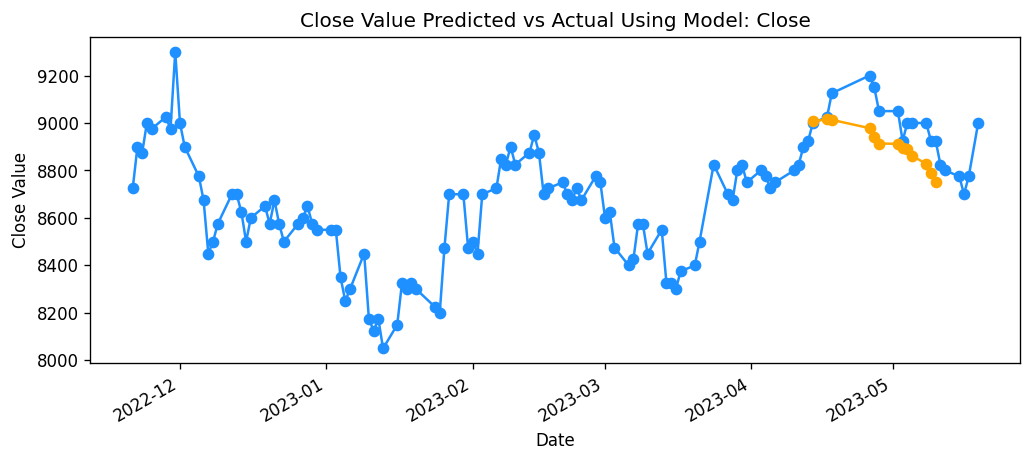

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10,4))

df.Close.plot(marker='o', color='dodgerblue', ax=ax)
predicted_Y_Close.Predicted.plot(marker='o', color='orange', ax=ax)
plt.title('Close Value Predicted vs Actual Using Model: Close')
plt.xlabel('Date')
plt.ylabel('Close Value')
plt.show()

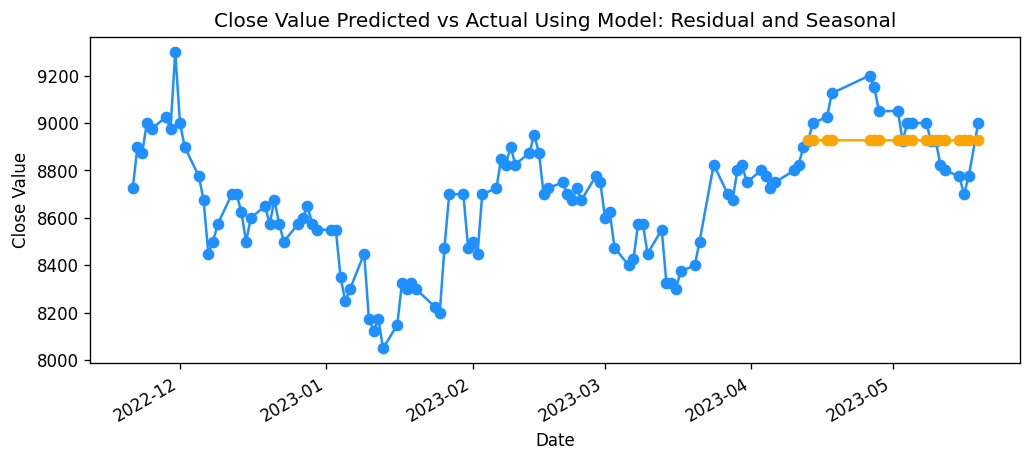

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10,4))

df.Close.plot(marker='o', color='dodgerblue', ax=ax)
result_ARIMA_LSTM.Predicted_Close.plot(marker='o', color='orange', ax=ax)
plt.title('Close Value Predicted vs Actual Using Model: Residual and Seasonal')
plt.xlabel('Date')
plt.ylabel('Close Value')
plt.show()